In [1]:
import numpy as np # library to handle data in a vectorized manner 

import pandas as pd # library for data analsysis

# Input data files are available in the read-only "../input/" directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/gender_submission.csv
/kaggle/input/test.csv
/kaggle/input/train.csv


In [2]:
# import necessary libraries
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

In [3]:
# Read train data from file 
train_data = pd.read_csv("/kaggle/input/train.csv")
# Preview the first 5 lines of the loaded data
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Read test data from file 
test_data = pd.read_csv("/kaggle/input/test.csv")
# Preview the first 5 lines of the loaded data
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
# Return the values. 
women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)
# Print the result.
print("% of women who survived:", rate_women)

% of women who survived: 0.7420382165605095


In [6]:
# Return the values. 
men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)
# Print the result.
print("% of men who survived:", rate_men)

% of men who survived: 0.18890814558058924


In [7]:
# To print the full summary of train data.
train_data.info()
print("-" * 40)
# To print the full summary of test data.
test_data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passenger

It can be seen that numeric fields such as Age/Cabin/Embarked have missing values, and the problem of missing values should be dealt with first in the later analysis.

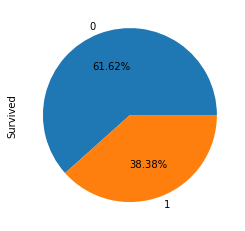

In [8]:
# Draw the survival ratio
train_data['Survived'].value_counts().plot.pie(autopct = '%1.2f%%')

Among the 891 passengers, the proportions of surviving and unsurviving were 38% and 62%, respectively.

<h2> Methods of processing missing values </h2>

Embarked is missing two values ​​and can be assigned with the mode.

In [9]:
# Fill the Embarked with the mode
train_data.Embarked[train_data.Embarked.isnull()] = train_data.Embarked.dropna().mode().values

For the nominal attribute,assign a missing value, such as ‘NC’. 

In [10]:
train_data['Cabin'] = train_data.Cabin.fillna('NC')

Because Age is a very important feature in this data set, for the current data, the random forest prediction model is used here, and the numerical attributes in the data set are selected as features (because the sklearn model can only handle numerical attributes, so here is only Select numerical features, but need to convert non-numerical features to numerical features in actual applications)

In [11]:
from sklearn.ensemble import RandomForestRegressor

#choose training data to predict age
age_df = train_data[['Age','Survived','Fare', 'Parch', 'SibSp', 'Pclass']]
age_df_notnull = age_df.loc[(train_data['Age'].notnull())]
age_df_isnull = age_df.loc[(train_data['Age'].isnull())]
X = age_df_notnull.values[:,1:]
Y = age_df_notnull.values[:,0]
# use RandomForestRegression to train data
RFR = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
RFR.fit(X,Y)
predictAges = RFR.predict(age_df_isnull.values[:,1:])
train_data.loc[train_data['Age'].isnull(), ['Age']]= predictAges

In [12]:
# To print the full summary of train data.
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


<h2> Analyze data relationships </h2>

<h2>Gender</h2>

In [13]:
train_data.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

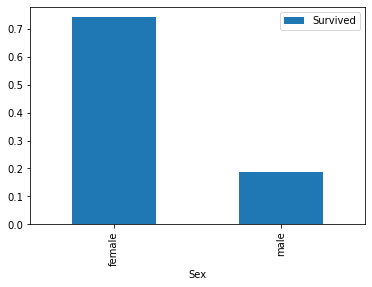

In [14]:
train_data[['Sex','Survived']].groupby(['Sex']).mean().plot.bar()

The above are the survival rates of different genders. It can be seen that Lady First was still reflected in the Titanic accident.

<h2>Canbin</h2>

In [15]:
train_data.groupby(['Pclass','Survived'])['Pclass'].count()

Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
Name: Pclass, dtype: int64

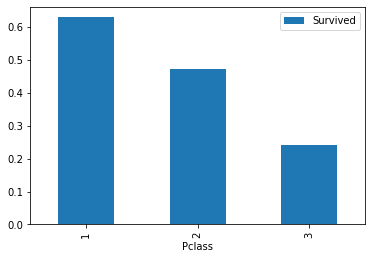

In [16]:
train_data[['Pclass','Survived']].groupby(['Pclass']).mean().plot.bar()

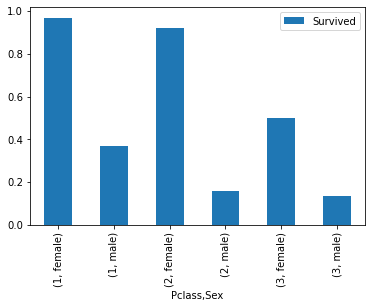

In [17]:
train_data[['Pclass','Survived','Sex']].groupby(['Pclass','Sex']).mean().plot.bar()

In [18]:
train_data.groupby(['Sex','Pclass','Survived'])['Survived'].count()

Sex     Pclass  Survived
female  1       0             3
                1            91
        2       0             6
                1            70
        3       0            72
                1            72
male    1       0            77
                1            45
        2       0            91
                1            17
        3       0           300
                1            47
Name: Survived, dtype: int64

It can be seen from the figure and table that, in general, the escape of the Titanic is women's priority, but there are still certain differences for cabins of different classes.

<h2> Age Group </h2>

<h3> Analyze over all Age Group distribution: </h3>

In [19]:
bins = [0, 12, 18, 65, 100]
train_data['Age_group'] = pd.cut(train_data['Age'], bins)
by_age = train_data.groupby('Age_group')['Survived'].mean()
by_age

Age_group
(0, 12]      0.506173
(12, 18]     0.466667
(18, 65]     0.364512
(65, 100]    0.125000
Name: Survived, dtype: float64

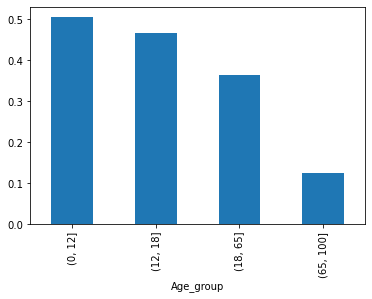

In [20]:
by_age.plot(kind = 'bar')

The survival rate of young people is higher than that of adults.

<h2> Parch </h2>

In [21]:
# Divided into two groups with and without Parents and children
parch_df = train_data[train_data['Parch'] != 0]
no_parch_df = train_data[train_data['Parch'] == 0]

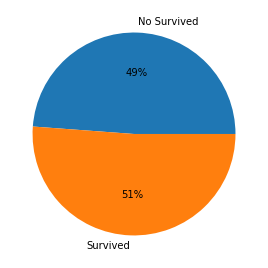

In [22]:
# Survival rate of passengers with parents and children
plt.figure(figsize=(10,5))

plt.subplot(122)
plt.pie([parch_df['Survived'][parch_df['Survived'] == 0].count(),parch_df['Survived'].sum()],\
        labels=['No Survived', 'Survived'],autopct='%1.0f%%')
plt.show()


In [23]:
parch_df['Survived'].sum()

109

For passengers with parents or children on the same boat, 109 people survived, and the survival rate was 51%.

<h2> SibSp </h2>

In [24]:
# Divided into two groups with and without siblings
sibsp_df = train_data[train_data['SibSp'] != 0]
no_sibsp_df = train_data[train_data['SibSp'] == 0]

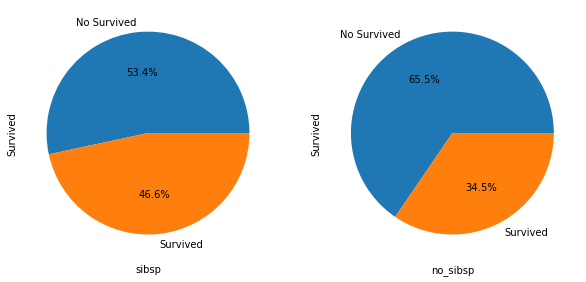

In [25]:
# Survival rate of passengers with and without siblings
plt.figure(figsize=(10,5))
plt.subplot(121)
sibsp_df['Survived'].value_counts().plot.pie(labels=['No Survived', 'Survived'], autopct = '%1.1f%%')
plt.xlabel('sibsp')

plt.subplot(122)
no_sibsp_df['Survived'].value_counts().plot.pie(labels=['No Survived', 'Survived'], autopct = '%1.1f%%')
plt.xlabel('no_sibsp')

plt.show()

Passengers with siblings,the survival rate was 47%.
Passengers without siblings,the survival rate was 35%.

<h2> Fare </h2>

<h3> Analyze over all Fare distribution: </h3>

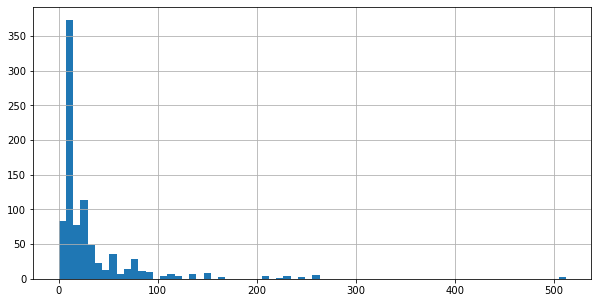

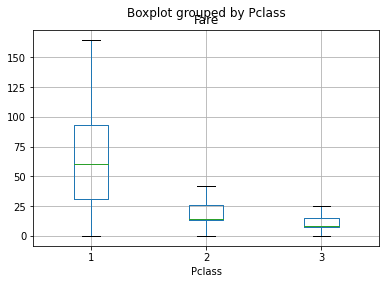

In [26]:
plt.figure(figsize=(10,5))
train_data['Fare'].hist(bins = 70)

train_data.boxplot(column='Fare', by='Pclass', showfliers=False)
plt.show()

In [27]:
# Fare distribution
train_data['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

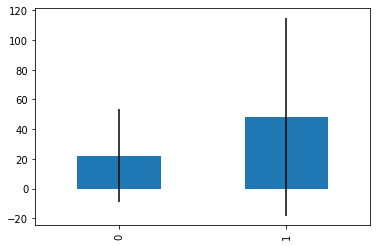

In [28]:
fare_not_survived = train_data['Fare'][train_data['Survived'] == 0]
fare_survived = train_data['Fare'][train_data['Survived'] == 1]

average_fare = pd.DataFrame([fare_not_survived.mean(), fare_survived.mean()])
std_fare = pd.DataFrame([fare_not_survived.std(), fare_survived.std()])
average_fare.plot(yerr=std_fare, kind='bar', legend=False)

plt.show()

It can be seen that there is still a certain correlation between ticket prices and survival, and the average ticket price of survivors is higher than that of those who have not survived.

<h2> Embarked </h2>

<h3> Analyze over all Embarked distribution: </h3>

Text(0.5, 1.0, 'Embarked and Survived')

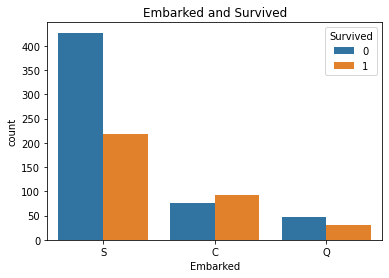

In [29]:
sns.countplot('Embarked', hue='Survived', data=train_data)
plt.title('Embarked and Survived')

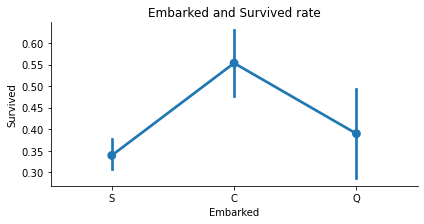

In [30]:
sns.factorplot('Embarked', 'Survived', data=train_data, size=3, aspect=2)
plt.title('Embarked and Survived rate')
plt.show()

The survival rate of the ship from C is the highest, Q is the second, and S is the lowest.

<h2> Number of people on board, number of survivors and survival rate of each port</h2>

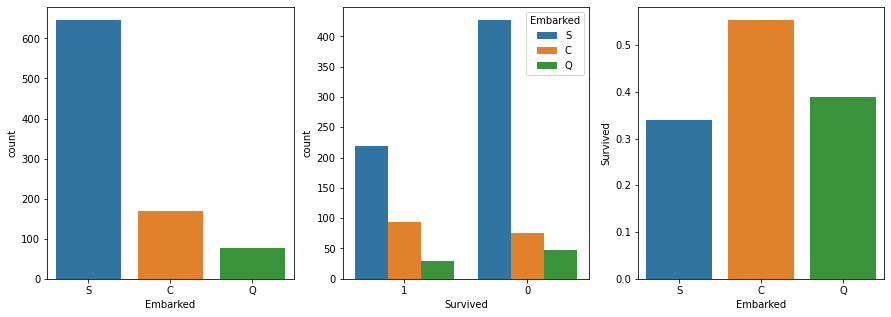

In [32]:
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5)) 

sns.countplot(x='Embarked', data=train_data, ax=axis1)
sns.countplot(x='Survived', hue="Embarked", data=train_data, order=[1,0], ax=axis2)

embark_perc = train_data[["Embarked", "Survived"]].groupby(['Embarked'],as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embark_perc,order=['S','C','Q'],ax=axis3)

plt.show()

Port S has the most survivors, followed by C and Q the least. From the point of view of survival rate, the survival rate of the ship in Port C is the highest, followed by Q, and the survival rate of S is the lowest.

<h1> Conclusion </h1>

The survival rate is correlated with gender,passenger class, age, parents and children,sbilings,fare, and port of embarkation; name, ticket information, and cabin are related to text processing or missing values Too many reasons are excluded from the scope of this analysis. The specific correlation between the relevant factors and the probability of rescue is as follows:
<ol>
<li>Women have a higher survival rate than men.</li>

<li>There is a positive relationship between passenger level and survival rate, with level 1 being the highest and level 3 being the lowest.</li>


<li>In terms of age, passengers aged 0-17 have the highest chance of being survived, those over 60 have the lowest chance, and the chances are in the middle range.</li>

<li> For passengers with parents or children on the same boat, 109 people survived, and the survival rate was 51%.</li>
    
<li> Passengers with siblings,the survival rate was 47%,which is higher than passengers without siblings.</li>

<li> The ticket price has a positive relationship with the probability of being survived. The higher the ticket price, the greater the chance of survival.</li>

<li>There is also a correlation between the location of the port where passengers board the ship and the probability of survival. Port C is the highest, followed by Q, and again S. </li>
</ol>